In [1]:
from pandas import read_csv
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
import copy
import itertools

%matplotlib inline

In [2]:
IMAGE_SIZE = 96

Чтение данных (пока нужен только training.csv)

In [3]:
#id_lookup = read_csv("../IdLookupTable.csv")
#sample_submission = read_csv("../SampleSubmission.csv")
#test = read_csv("../test.csv")
training = read_csv("../training.csv")

Изображение записано в виде строки чисел от 0 до 255, разделенных пробелом. Преобразуем эту строку к массиву чисел 0-255

In [4]:
training.Image = training.Image.apply(lambda img: np.fromstring(img, sep=' '))

Отбрасывание примеров, в которых заполнены поля не для всех признаков. Из ~7000 изображение остается ~2000

In [5]:
training = training.dropna()
#training = training.fillna(-1)

labels - правильные координаты признаков, используемые для обучения сети

In [6]:
labels = np.array([])
for key_name in training.columns.values[:-1]:
    labels = np.append(labels, np.array(training[key_name]))
labels = labels.reshape(training.shape[1]-1, len(training.Image)).T

Для примера выведем на экран размерность массива признаков в виде (кол-во строк; кол-во признаков для одного изображения).
И также выведем признаки для первого изображения

In [7]:
print labels.shape
print labels[0]

(2140, 30)
[ 66.03356391  39.00227368  30.22700752  36.4216782   59.58207519
  39.64742256  73.13034586  39.96999699  36.35657143  37.3894015
  23.45287218  37.3894015   56.95326316  29.03364812  80.22712782
  32.22813835  40.22760902  29.0023218   16.35637895  29.64747068
  44.42057143  57.06680301  61.19530827  79.97016541  28.61449624
  77.38899248  43.3126015   72.93545865  43.13070677  84.48577444]


Функция для вывода изображения на экран

In [8]:
def print_image(data):
    img = [[x]*3 for x in data]
    img = np.reshape(img, (96,96,3))
    plt.imshow(img)

Функция для печати изображения с нанесенными признаками

In [39]:
def test_point(img_ind, a, b, length):
    plt.xlim([0, 96])
    plt.ylim([96, 0])
    f = teX[img_ind].reshape(96*96)
    print_image(f)
    for i in range(length):
        plt.plot(a[img_ind][i][0],a[img_ind][i][1], 'r*')
        plt.plot(b[img_ind][i][0],b[img_ind][i][1], 'bo')
    plt.show()

Функции для масштабирование признаков в прямую ((0; 96) -> (-1; 1)) и обратную сторону

In [10]:
def scale(x):
    return (x - 48) / 48
    #return x / 96.0
def unscale(x):
    return x * 48 + 48
    #return x * 96.0

Объявление массива образцов для обучения и тестирования, печать его размерности и первого элемента

In [11]:
#t_samples = np.array([np.copy(img) for img in training.Image[0:1000].apply(lambda x: x / 255.0)])
t_samples = np.array([np.copy(img) for img in training.Image[:2048].apply(lambda x: x / 255.0)])
print t_samples.shape
print t_samples[0]

(2048, 9216)
[ 0.93333333  0.9254902   0.92941176 ...,  0.2745098   0.29411765
  0.35294118]


Масштабирование признаков и печать первого элемента до масштабирования и после

In [12]:
print labels[0]
t_labels = scale(labels)
print t_labels[0]

[ 66.03356391  39.00227368  30.22700752  36.4216782   59.58207519
  39.64742256  73.13034586  39.96999699  36.35657143  37.3894015
  23.45287218  37.3894015   56.95326316  29.03364812  80.22712782
  32.22813835  40.22760902  29.0023218   16.35637895  29.64747068
  44.42057143  57.06680301  61.19530827  79.97016541  28.61449624
  77.38899248  43.3126015   72.93545865  43.13070677  84.48577444]
[ 0.37569925 -0.18745263 -0.37027068 -0.24121504  0.24129323 -0.17401203
  0.52354887 -0.16729173 -0.24257143 -0.22105414 -0.5113985  -0.22105414
  0.18652632 -0.39513233  0.6713985  -0.32858045 -0.16192481 -0.39578496
 -0.65924211 -0.38234436 -0.07457143  0.18889173  0.27490226  0.66604511
 -0.40386466  0.61227068 -0.09765414  0.51948872 -0.10144361  0.7601203 ]


Функция для инициализации весов (задаются размерности матриц (тензоров))

In [13]:
def init_weights(shape):
    #return tf.Variable(tf.random_normal(shape, stddev=0.01))
    return tf.Variable(tf.truncated_normal(shape, stddev=0.01))

Задание размеров обучающей и тестирующей выборки и вывод их на экран

In [14]:
full_volume = len(t_samples)
train_volume = int(full_volume * 0.875)
test_volume = full_volume - train_volume
print "%d\n%d\n%d" % (full_volume, train_volume, test_volume)

2048
1792
256


Задание обучающей и тестирующей выборки

In [15]:
trX = np.array(t_samples[:train_volume], dtype=np.float)
teX = np.array(t_samples[train_volume:full_volume], dtype=np.float)
trY = np.array(t_labels[:train_volume], dtype=np.float)
teY = np.array(t_labels[train_volume:full_volume], dtype=np.float)

trX = trX.reshape(-1, 96, 96, 1)  # 96x96x1 input img
teX = teX.reshape(-1, 96, 96, 1)  # 96x96x1 input img

Модель сверточной нейронной сети. p_keep_conv, p_keep_hidden - вероятности сохранения (не отбрасывания) нейрона при обучении после применения dropout

In [84]:
# def model(X, w, w2, w3, w4, w_o, p_keep_conv, p_keep_hidden, show_shapes=False):
    
#     l1 = tf.nn.relu(tf.nn.conv2d(X, w,                       # l1 shape=(?, 96, 96, 32)
#                         strides=[1, 1, 1, 1], padding='SAME'))
#     l1_shape = l1.get_shape()
#     l1 = tf.nn.max_pool(l1, ksize=[1, 2, 2, 1],              # l1 shape=(?, 48, 48, 32)
#                         strides=[1, 2, 2, 1], padding='SAME')
#     l1 = tf.nn.dropout(l1, p_keep_conv)

#     l2 = tf.nn.relu(tf.nn.conv2d(l1, w2,                     # l2a shape=(?, 48, 48, 64)
#                         strides=[1, 1, 1, 1], padding='SAME'))
#     l2_shape = l2.get_shape()
#     l2 = tf.nn.max_pool(l2, ksize=[1, 2, 2, 1],              # l2 shape=(?, 24, 24, 64)
#                         strides=[1, 2, 2, 1], padding='SAME')
#     l2 = tf.nn.dropout(l2, p_keep_conv)
    
#     l3 = tf.nn.relu(tf.nn.conv2d(l2, w3,                     # l3a shape=(?, 24, 24, 128)
#                         strides=[1, 1, 1, 1], padding='SAME'))
#     l3_shape = l3.get_shape()
#     l3 = tf.nn.max_pool(l3, ksize=[1, 3, 3, 1],              # l3 shape=(?, 8, 8, 128)
#                         strides=[1, 3, 3, 1], padding='SAME')
#     l3_after_maxpool_shape = l3.get_shape()
#     l3 = tf.reshape(l3, [-1, w4.get_shape().as_list()[0]])    # reshape to (?, 2048)
#     l3 = tf.nn.dropout(l3, p_keep_conv)

#     l4 = tf.nn.relu(tf.matmul(l3, w4))
#     #l4 = tf.nn.tanh(tf.matmul(l3, w4))
#     l4 = tf.nn.dropout(l4, p_keep_hidden)
    
#     #l5 = tf.nn.relu(tf.matmul(l4, w5))
#     #l5 = tf.nn.dropout(l5, p_keep_hidden)

#     y = tf.matmul(l4, w_o)
#     #pyx = tf.nn.tanh(tf.matmul(l4, w_o))
    
#     if show_shapes:
#         print 'X: ', X.get_shape()
#         print 'l1: ', l1_shape
#         print 'l1 after max pool: ', l1.get_shape()
#         print 'l2: ', l2_shape
#         print 'l2 after max pool: ', l2.get_shape()
#         print 'l3: ', l3_shape
#         print 'l3 after max pool: ', l3_after_maxpool_shape
#         print 'w4.get_shape().as_list()[0]: ', w4.get_shape().as_list()[0]
#         print 'l3 after reshape: ', l3.get_shape()
#         print 'l4: ', l4.get_shape()
#         #print 'l5: ', l5.get_shape()
#         print 'pyx: ', y.get_shape()
#     return y

Объявление placeholder'ов и инициализация весов

In [85]:
# X = tf.placeholder("float", [None, 96, 96, 1], name="X")
# Y = tf.placeholder("float", [None, training.shape[1]-1], name="Y")

# w = init_weights([3, 3, 1, 32])       # 3x3x1 conv, 32 outputs
# w2 = init_weights([3, 3, 32, 64])     # 3x3x32 conv, 64 outputs
# w3 = init_weights([3, 3, 64, 128])    # 3x3x32 conv, 128 outputs
# w4 = init_weights([128 * 8 * 8, 625]) # Fully connected 128 * 4 * 4 inputs, 625 outputs
# #w5 = init_weights([2000, 625]) # FC 2000 input, 625 output
# w_o = init_weights([625, training.shape[1]-1])         # FC 625 inputs, 2 outputs (labels)

# p_keep_conv = tf.placeholder("float", name="p_keep_conv")
# p_keep_hidden = tf.placeholder("float", name="p_keep_hidden")

# pred = model(X, w, w2, w3, w4, w_o, p_keep_conv, p_keep_hidden, show_shapes=False)

Задание eps для проверки точности работы нейросети, а также размеров одновременно подаваемых образцов для обучения (они подаются нейросети, вычисляется средняя ошибка для всех этих образцов и только после этого меняются веса) и тестирования

In [16]:
eps = 3# treshold = 3 pixels #0.01
batch_size = 128

После каждой эпохи обучения скорость обучения будет уменьшаться

In [17]:
# global_step = tf.Variable(1, trainable=False)
# starter_learning_rate = 0.001
# learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step * batch_size,
#                                            train_volume, 0.96, staircase=True)

Задание вычислительных узлов графа tensorflow
+ Стоимость - среднеквадратичная ошибка
+ Метод обучения - RMSProp

In [30]:
#cost = (tf.nn.l2_loss(py_x - Y))
#cost = tf.reduce_mean(tf.reduce_sum(tf.square(pred - Y)))

#train_op = tf.train.RMSPropOptimizer(learning_rate, 0.9).minimize(cost, global_step=global_step)
#train_op = tf.train.AdamOptimizer().minimize(cost, global_step=global_step)

#predict_op = pred

Функции для оценки точности. Проверяется что все сравниваемые элементы отличаются не более чем на eps

In [17]:
# def eq_eps(y, yl):
#     return np.abs(y - yl) < eps

# def all_eq_eps(y, yl):
#     return (all(eq_eps(yc, ylc)) for yc, ylc in zip(y, yl))
def eq_eps(y, yl):
    uy = unscale(y)
    uyl = unscale(yl)
    return np.abs(uy - uyl) < eps

def all_eq_eps(y, yl):
    return (all(eq_eps(yc, ylc)) for yc, ylc in zip(y, yl))

In [18]:
class ConfigNN:
    def __init__(self, input_img_size, output_count, opt, cost, lrn_rate,
                 changing_learning_rate, conv_kernels, pooling_kernels,
                 fc_layers, keep_prob_conv, keep_prob_fc,
                 batch_size, train_volume, epochs):
        # img_size = 96x96, not (-1, 96, 96, 1)
        # pooling_kernels = [...,(1,2,2,1), ...]
        # conv_kernel = [width, height, count]
        self.input_img_size = input_img_size # ?
        self.output_count = output_count
        self.optimizer = opt
        self.train_volume = train_volume
        self.batch_size = batch_size
        self.epochs = epochs
        self.changing_learning_rate = changing_learning_rate
        
        self.pooling_kernels_shapes =copy.deepcopy(pooling_kernels) #np.copy(pooling_kernels)
        
        self.keep_prob_conv = keep_prob_conv
        self.keep_prob_fc = keep_prob_fc
        
        self._create_weights(conv_kernels, fc_layers)
        
        self.X = tf.placeholder("float",[None, self.input_img_size[0], self.input_img_size[1], 1], name="X")
        self.Y = tf.placeholder("float",[None, self.output_count], name="Y")
        
        if changing_learning_rate:
            self.global_step = tf.Variable(1, trainable=False)
            self.learning_rate = tf.train.exponential_decay(lrn_rate, self.global_step * batch_size,
                                           train_volume, 0.96, staircase=True)
        else:
            self.learning_rate = lrn_rate
            
        self.predict_op = self._predict(self.X)
        #self.predict_op_train = self._predict(self.X)
        self.cost = cost(self.Y - self.predict_op)
        #self.cost = tf.reduce_mean(tf.reduce_sum(tf.square(self.Y - self.predict_op)))
        if changing_learning_rate:
            self.train_op = self.optimizer(self.learning_rate).minimize(self.cost, global_step=self.global_step)
        else:
            self.train_op = self.optimizer(self.learning_rate).minimize(self.cost)
            
    def print_info(self):
        print 'image size: ', self.input_img_size
        print 'outputs count: ', self.output_count
        print 'optimizer: ', self.optimizer
        print 'train volume: ', self.train_volume
        print 'batch size: ', self.batch_size
        print 'convolutional kernel shapes: ', self.conv_kernels_shapes
        print 'pooling kernels shapes: ', self.pooling_kernels_shapes
        print 'fully connected shapes: ', self.fc_layers_shapes
        print 'keep_prob for conv layers', self.keep_prob_conv
        print 'keep_prob for fc layers', self.keep_prob_fc
    
    def _init_weights(self, shape):
        #return tf.Variable(tf.random_normal(shape, stddev=0.01))
        return tf.Variable(tf.truncated_normal(shape, stddev=0.01))
    
    def _create_weights(self, conv_kernels, fc_layers):
        # предполагается что ядра свертки и субдискретизации имеют размеры NxN
        
        self.conv_kernels_shapes = copy.deepcopy(conv_kernels)
        self.fc_layers_shapes = copy.deepcopy(fc_layers)
        
        self.conv_kernels_shapes[0][2:] = [1, self.conv_kernels_shapes[0][2]]
        for i in range(1, len(self.conv_kernels_shapes)):
            self.conv_kernels_shapes[i][2:] = [self.conv_kernels_shapes[i-1][-1], self.conv_kernels_shapes[i][2]]
            
        img_sz = self.input_img_size[0]
        for pk in self.pooling_kernels_shapes:
            img_sz /= pk[1]
            
        conv_output_count = self.conv_kernels_shapes[-1][3] * img_sz * img_sz
        #print conv_output_count
        self.fc_layers_shapes[0] = [conv_output_count, self.fc_layers_shapes[0]]

        for i in range(1, len(self.fc_layers_shapes)):
            self.fc_layers_shapes[i] = [self.fc_layers_shapes[i-1][1], self.fc_layers_shapes[i]]
        
        #print 'cks'
        #for cks in self.conv_kernels_shapes:
            #print cks
        self.conv_kernels = [self._init_weights(sh) for sh in self.conv_kernels_shapes]
        #print 'fcl'
        #for fcl in self.fc_layers_shapes:
            #print fcl
        self.fc_layers = [self._init_weights(sh) for sh in self.fc_layers_shapes]
    
    def _predict(self, X):
        # x.reshape(-1, 96, 96, 1) # ?
        y = X#self.X
        for (conv, pooling) in zip(self.conv_kernels, self.pooling_kernels_shapes):
            #print conv, pooling
            y = tf.nn.relu(tf.nn.conv2d(y, conv, strides=[1,1,1,1], padding="SAME"))
            #print y
            y = tf.nn.max_pool(y, pooling, pooling, padding="SAME")
            #print y
            y = tf.nn.dropout(y, self.keep_prob_conv)
        #print y.get_shape().as_list()
        #print self.fc_layers_shapes[0][0]
        y = tf.reshape(y, [-1, self.fc_layers_shapes[0][0]])
        #transfer_conv_to_fc_layers = init_weights(y.get_shape[1], self.fc_layers[0].get_shape()) # ?!
        #y = tf.relu(tf.matmul(y,transfer_conv_to_fc_layers))
        for l in self.fc_layers[:-1]:
            y = tf.nn.relu(tf.matmul(y, l))
            y = tf.nn.dropout(y, self.keep_prob_fc)
        y = tf.matmul(y, self.fc_layers[-1])
        return y

In [19]:
# detect_points_count = training.shape[1]-1
# cost = lambda x: tf.reduce_mean(tf.reduce_sum(tf.square(x)))
# cn = ConfigNN([96,96], detect_points_count, tf.train.RMSPropOptimizer, cost, 0.001, False,
#                conv_kernels=[[3,3,32],[3,3,64],[3,3,128]],
#               pooling_kernels=[[1,2,2,1],[1,2,2,1],[1,3,3,1]],
#               fc_layers=[625, detect_points_count],
#               keep_prob_conv=0.8,
#               keep_prob_fc=0.5,
#               batch_size=batch_size, train_volume=train_volume, epochs=3)
# cn.print_info()
#predict_op, train_op = cn.create_net()

image size:  [96, 96]
outputs count:  30
optimizer:  <class 'tensorflow.python.training.rmsprop.RMSPropOptimizer'>
train volume:  1792
batch size:  128
convolutional kernel shapes:  [[3, 3, 1, 32], [3, 3, 32, 64], [3, 3, 64, 128]]
pooling kernels shapes:  [[1, 2, 2, 1], [1, 2, 2, 1], [1, 3, 3, 1]]
fully connected shapes:  [[8192, 625], [625, 30]]
keep_prob for conv layers 0.8
keep_prob for fc layers 0.5


In [20]:
optimizers = [tf.train.RMSPropOptimizer, tf.train.AdamOptimizer]

rms = lambda x: tf.reduce_mean(tf.reduce_sum(tf.square(x)))
l2 = lambda x: tf.nn.l2_loss(x)
costs = [rms, l2]

changing_learing_rate = [True]#[False, True]

conv3_4 = [3,3,4]
conv3_8 = [3,3,8]
conv3_16 = [3,3,16]
conv3_32 = [3,3,32]
conv3_64 = [3,3,64]
conv3_128 = [3,3,128]
conv2_4 = [2,2,4]
conv2_8 = [2,2,8]
conv2_16 = [2,2,16]
conv2_32 = [2,2,32]
conv2_64 = [2,2,64]
conv2_128 = [2,2,128]

conv_kernels = [[conv3_4,conv3_8,conv3_16],
                #[conv3_32, conv3_64, conv3_128],
                #[conv2_32, conv3_64, conv2_128],
                [conv2_16, conv2_32, conv2_64]]

pooling2 = [1,2,2,1]
pooling3 = [1,3,3,1]
pooling4 = [1,4,4,1]
poolings = [[pooling4, pooling3, pooling2],
           [pooling2, pooling2, pooling3]]

fc_layers = [[512, 512, detect_points_count],
             [625, detect_points_count]]

#kprobs_conv = [0.8]

#kprobs_fc = [0.5]

epochs = [10]

In [21]:
network_params = list(itertools.product(optimizers, costs, changing_learing_rate,
                                   conv_kernels, poolings, fc_layers))
                                   #kprobs_conv, kprobs_fc, epochs))
print len(network_params)
print network_params[0]

32
(<class 'tensorflow.python.training.rmsprop.RMSPropOptimizer'>, <function <lambda> at 0x7f840db96050>, True, [[3, 3, 4], [3, 3, 8], [3, 3, 16]], [[1, 4, 4, 1], [1, 3, 3, 1], [1, 2, 2, 1]], [512, 512, 30])


In [40]:
#sess.run(tf.initialize_all_variables())

def run(cn):
    try:
        sess.run(tf.initialize_all_variables())
        training_batch = zip(range(0, cn.train_volume, cn.batch_size),
                         range(cn.batch_size, cn.train_volume, cn.batch_size))

        kp_conv = cn.keep_prob_conv
        kp_fc = cn.keep_prob_fc
        if not cn.changing_learning_rate:
            cur_learning_rate = cn.learning_rate
    
        for i in range(cn.epochs):
            for start, end in training_batch:
        
                feed_dict={cn.X: trX[start:end], cn.Y: trY[start:end]}
                if cn.changing_learning_rate:
                    _, cst, cur_learning_rate = sess.run([cn.train_op, cn.cost, cn.learning_rate], feed_dict=feed_dict)
                else:
                    _, cst = sess.run([cn.train_op, cn.cost], feed_dict=feed_dict)
                
            cn.keep_prob_conv = 1.0
            cn.keep_prob_fc = 1.0
            y = sess.run(cn.predict_op, feed_dict={cn.X: teX})
            cn.keep_prob_conv = kp_conv
            cn.keep_prob_fc = kp_fc

            acc = [eq_eps(a,b) for (a,b) in zip(teY, y)]
            accuracy = np.mean(acc)
            print "Epoch: %d;   Cost: %7.3f;   Accuracy: %.0f%%;   Learning rate: %.5f" % (i, cst, accuracy*100, cur_learning_rate)
        
        cn.keep_prob_conv = 1.0
        cn.keep_prob_fc = 1.0
        y = sess.run(cn.predict_op, feed_dict={cn.X: teX})
        cn.keep_prob_conv = kp_conv
        cn.keep_prob_fc = kp_fc
        a, b = unscale(y[0:10]), unscale(teY[0:10])
        print a[1]
        print b[1]
        length = len(a[0]) / 2
        a = a.reshape(10, length, 2)
        b = b.reshape(10, length, 2)
        for i in range(10):
            test_point(i, a, b, length)
    except Exception as e:
        print "===============\nERROR: %s\n===============" % e

In [ ]:
for param in network_params:
    cn = ConfigNN([96,96], detect_points_count, param[0], param[1], 0.001, param[2],
               conv_kernels=param[3],
              pooling_kernels=param[4],
              fc_layers=param[5],
              keep_prob_conv=0.8,
              keep_prob_fc=0.5,
              batch_size=batch_size, train_volume=train_volume, epochs=10)
    cn.print_info()
    run(cn)
    

image size:  [96, 96]
outputs count:  30
optimizer:  <class 'tensorflow.python.training.rmsprop.RMSPropOptimizer'>
train volume:  1792
batch size:  128
convolutional kernel shapes:  [[3, 3, 1, 4], [3, 3, 4, 8], [3, 3, 8, 16]]
pooling kernels shapes:  [[1, 4, 4, 1], [1, 3, 3, 1], [1, 2, 2, 1]]
fully connected shapes:  [[256, 512], [512, 512], [512, 30]]
keep_prob for conv layers 0.8
keep_prob for fc layers 0.5
Epoch: 0;   Cost: 584.519;   Accuracy: 0%;   Learning rate: 0.00100
Epoch: 1;   Cost: 584.519;   Accuracy: 0%;   Learning rate: 0.00096
Epoch: 2;   Cost: 584.519;   Accuracy: 0%;   Learning rate: 0.00092
Epoch: 3;   Cost: 584.519;   Accuracy: 0%;   Learning rate: 0.00088
Epoch: 4;   Cost: 584.519;   Accuracy: 0%;   Learning rate: 0.00085
Epoch: 5;   Cost: 584.519;   Accuracy: 0%;   Learning rate: 0.00082
Epoch: 6;   Cost: 584.519;   Accuracy: 0%;   Learning rate: 0.00078


Запуск обучения.
* Создание сессии tensorflow
* Инициализация переменных
* Задание кол-ва эпох
* Разделение обучающей выборки на равные части (batch) размером batch_size
* Каждую эпоху:
  - Для каждого batch
    + Запустить обучение на этой части выборки
  - Запустить сеть на тестирующей выборке
  - Вычислить процент правильных результатов
  - Напечатать результат

In [23]:
sess = tf.Session()

In [79]:
sess.run(tf.initialize_all_variables())

In [101]:
print cn.fc_layers[0].eval(session=sess)

In [81]:
print cn.fc_layers[-1].eval(session=sess)

[[-0.00936145 -0.00038735  0.00533968 ...,  0.00298649  0.00332681
   0.00505227]
 [ 0.00011087  0.01056383 -0.01669799 ..., -0.00512576 -0.00536478
  -0.00203449]
 [ 0.01369606  0.01079302  0.00543574 ..., -0.01168886  0.00352975
   0.00175144]
 ..., 
 [-0.00498623  0.00162942 -0.01731752 ...,  0.00393259 -0.00362005
  -0.00161506]
 [ 0.010472   -0.01429161  0.00221697 ...,  0.00207525 -0.01403153
  -0.00127202]
 [-0.01044798 -0.00833761  0.00521606 ...,  0.00471944  0.00662471
   0.0012036 ]]


Запустить сеть на первых 10 изображениях из тестового множества. И отмасштабировать к (0; 96).

In [83]:
#y = sess.run(predict_op, feed_dict={X: teX[0:10], p_keep_conv: 1.0, p_keep_hidden: 1.0})
cn.keep_prob_conv = 1.0
cn.keep_prob_fc = 1.0
y = sess.run(cn.predict_op, feed_dict={cn.X: teX})
a, b = unscale(y[0:10]), unscale(teY[0:10])

Вывести на экран результат работы сети (a) и правильный результат (b) для одного и того же изображения

In [84]:
print a[1]
print b[1]

[ 67.50524902  33.53167725  21.47241592  35.46604156  63.00045013
  36.97631836  81.83804321  35.40143585  33.90164948  34.81837463
  11.79742813  36.76226425  58.75456619  24.37294769  89.25086975
  27.0187149   35.97599411  23.87303352   4.92832565  26.31286621
  48.67193222  62.50453568  69.58486938  83.63917542  27.51805878
  87.19857788  49.2103653   81.24203491  50.0222702   94.49421692]
[ 67.45914619  36.85883376  29.1785432   36.99648165  58.47469558
  38.11271131  76.5862602   36.97028954  36.84530782  38.58639838
  20.82307483  38.37426068  54.18727591  33.2607453   84.47299019
  30.24947999  38.64637795  35.37209224  13.78797918  30.62467694
  43.94836069  64.11992358  68.1195102   83.01518367  36.08163265
  81.60065306  50.12767347  80.65763265  50.69844898  92.47020408]


In [74]:
print a[1]
print b[1]

[ 67.55906677  48.          48.          48.          58.43254852  48.
  76.75267029  48.          48.          48.          48.          48.
  56.2229538   48.          48.          48.          48.          48.          48.
  48.          48.          48.          67.69616699  48.          48.
  79.22131348  48.          48.          48.          86.89418793]
[ 67.45914619  36.85883376  29.1785432   36.99648165  58.47469558
  38.11271131  76.5862602   36.97028954  36.84530782  38.58639838
  20.82307483  38.37426068  54.18727591  33.2607453   84.47299019
  30.24947999  38.64637795  35.37209224  13.78797918  30.62467694
  43.94836069  64.11992358  68.1195102   83.01518367  36.08163265
  81.60065306  50.12767347  80.65763265  50.69844898  92.47020408]


Изменить размеры 

In [85]:
length = len(a[0]) / 2
a = a.reshape(10, length, 2)
b = b.reshape(10, length, 2)

Вывести на экран изображения с нанесением признаков (синий - правильные, красный - результат сети)

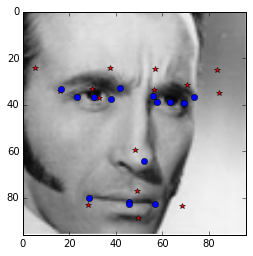

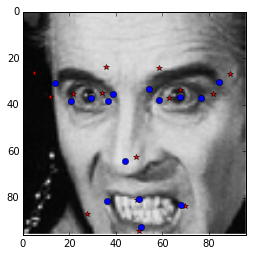

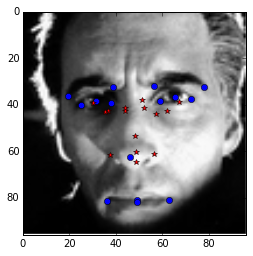

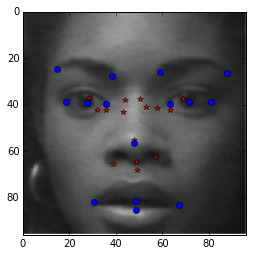

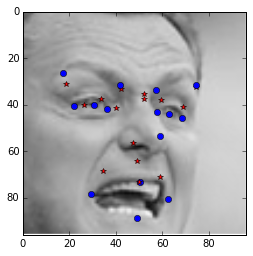

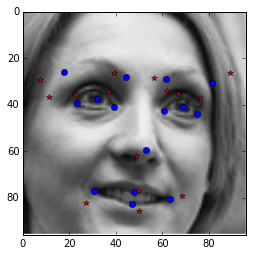

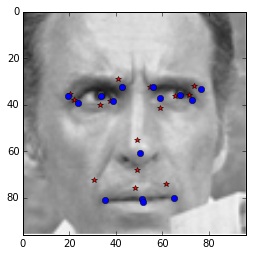

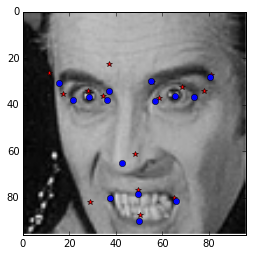

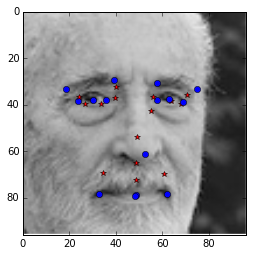

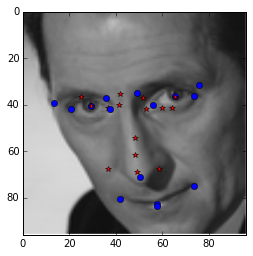

In [86]:
for i in range(10):
    test_point(i, a, b)

Вывести веса первого сверточного слоя ради интереса

In [94]:
print w.eval(session=sess)

[[[[  1.06160250e-02   1.73759386e-02   7.18647707e-03   8.46912339e-03
     -3.19966744e-03   3.10796150e-03   2.33948715e-02   1.31352674e-02
     -1.11970585e-03   8.96698143e-03  -1.77008694e-03   9.72431898e-03
      7.38274865e-03   1.29347863e-02  -1.23662734e-03  -2.67091393e-03
     -9.22673102e-03  -2.03163940e-02  -1.33165708e-02  -1.33040443e-03
      1.37314023e-02  -8.41799378e-03   1.17558716e-02   8.35728925e-03
     -5.14648343e-03  -2.44969456e-03  -1.42559288e-02  -1.05124693e-02
     -1.20644681e-02   2.83945929e-02  -2.31628842e-03   1.66973155e-02]]

  [[  1.09095322e-02  -1.44365923e-02   1.11847678e-02  -4.37812414e-03
      1.69326905e-02  -6.07915036e-03   1.05281649e-02   1.53096337e-02
      1.40868574e-02   1.46620851e-02  -1.11122336e-02   2.14962382e-02
     -3.43219173e-04  -2.14275718e-03   1.30049158e-02   3.85262398e-03
     -1.23208240e-02  -6.98952284e-03  -6.61926018e-03  -3.42234690e-03
      2.52529290e-02  -3.63372127e-03  -1.08634094e-02   1.31

Закрытие сессии tensorflow

In [43]:
sess.close()